In [27]:
import sys, os
BIN = os.path.expanduser("../../")
sys.path.append(BIN)

from __future__ import unicode_literals

import numpy as np
from scipy.constants import m_p, c, e, pi
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import LinearMap
from PyHEADTAIL.particles.particles import Particles
import PyHEADTAIL.particles.generators as generators
from PyHEADTAIL.particles.slicing import UniformBinSlicer, UniformChargeSlicer
from PyHEADTAIL_feedback.feedback import IdealBunchFeedback,IdealSliceFeedback
from PyHEADTAIL_feedback.processors import PhaseLinearizedLowpass, LowpassFilter, CosineSumRegister, HilbertRegister
from PyHEADTAIL_feedback.processors import ChargeWeighter, FermiDiracInverseWeighter, VectorSumRegister
from PyHEADTAIL_feedback.feedback import PickUp, Kicker
from PyHEADTAIL_feedback.mixers import Averager
np.random.seed(0)

In [28]:
def generate_bunch(n_macroparticles, alpha_x, alpha_y, beta_x, beta_y, linear_map):
    
    intensity = 1.05e11
    sigma_z = 0.059958
    gamma = 3730.26
    gamma_t = 1. / np.sqrt(alpha_0)
    p0 = np.sqrt(gamma**2 - 1) * m_p * c

    beta_z = (linear_map.eta(dp=0, gamma=gamma) * linear_map.circumference / 
              (2 * np.pi * linear_map.Qs))

    epsn_x = 3.75e-6 # [m rad]
    epsn_y = 3.75e-6 # [m rad]
    epsn_z = 4 * np.pi * sigma_z**2 * p0 / (beta_z * e) 
    
    bunch = generators.generate_Gaussian6DTwiss(
        macroparticlenumber=n_macroparticles, intensity=intensity, charge=e,
        gamma=gamma, mass=m_p, circumference=C,
        alpha_x=alpha_x, beta_x=beta_x, epsn_x=epsn_x,
        alpha_y=alpha_y, beta_y=beta_y, epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z)
    
    return bunch

In [29]:
def track(n_turns, bunch, total_map, bunch_dump):
    
    for i in xrange(n_turns):
        bunch_dump.dump()
        
        for m_ in total_map:
            m_.track(bunch)

In [30]:
class BunchTracker(object):
    def __init__(self,bunch):
        self.counter = 0

        self.bunch = bunch
        self.turn = np.array([])

        self.mean_x = np.array([])
        self.mean_y = np.array([])
        self.mean_z = np.array([])

        self.mean_xp = np.array([])
        self.mean_yp = np.array([])
        self.mean_dp = np.array([])

        self.sigma_x = np.array([])
        self.sigma_y = np.array([])
        self.sigma_z = np.array([])

        self.sigma_xp = np.array([])
        self.sigma_yp = np.array([])
        self.sigma_dp = np.array([])

        self.epsn_x = np.array([])
        self.epsn_y = np.array([])
        self.epsn_z = np.array([])

    def dump(self):
        self.turn=np.append(self.turn,[self.counter])
        self.counter += 1

        self.mean_x=np.append(self.mean_x,[self.bunch.mean_x()])
        self.mean_y=np.append(self.mean_y,[self.bunch.mean_y()])
        self.mean_z=np.append(self.mean_z,[self.bunch.mean_z()])

        self.mean_xp=np.append(self.mean_xp,[self.bunch.mean_xp()])
        self.mean_yp=np.append(self.mean_yp,[self.bunch.mean_yp()])
        self.mean_dp=np.append(self.mean_dp,[self.bunch.mean_dp()])

        self.sigma_x=np.append(self.sigma_x,[self.bunch.sigma_x()])
        self.sigma_y=np.append(self.sigma_y,[self.bunch.sigma_y()])
        self.sigma_z=np.append(self.sigma_z,[self.bunch.sigma_z()])

        self.sigma_xp=np.append(self.sigma_xp,[self.bunch.sigma_xp()])
        self.sigma_yp=np.append(self.sigma_yp,[self.bunch.sigma_yp()])
        self.sigma_dp=np.append(self.sigma_dp,[self.bunch.sigma_dp()])

        self.epsn_x = np.append(self.epsn_x,[self.bunch.epsn_x()])
        self.epsn_y = np.append(self.epsn_y,[self.bunch.epsn_y()])
        self.epsn_z = np.append(self.epsn_z,[self.bunch.epsn_z()])

In [31]:
def compare_traces(tracker_0,tracker_1,label_0,label_1):
    fig = plt.figure(figsize=(16, 8))
    ax_x_mean = fig.add_subplot(231)
    ax_x_sigma = fig.add_subplot(232)
    ax_x_epsn = fig.add_subplot(233)
    
    ax_x_mean.plot(tracker_0.turn, tracker_0.mean_x*1000,'k-', label=label_0)
    ax_x_mean.plot(tracker_1.turn, tracker_1.mean_x*1000,'b-', label=label_1)
    ax_x_mean.legend(loc='upper right')
    ax_x_mean.set_ylabel('<x> [mm]')
    ax_x_mean.ticklabel_format(useOffset=False)
    
    ax_x_sigma.plot(tracker_0.turn, tracker_0.sigma_x*1000,'k-',tracker_1.turn, tracker_1.sigma_x*1000,'b-')
    ax_x_sigma.set_ylabel('sigma_x [mm]')
    ax_x_sigma.ticklabel_format(useOffset=False)
    
    ax_x_epsn.plot(tracker_0.turn, tracker_0.epsn_x*1e6,'k-',tracker_1.turn, tracker_1.epsn_x*1e6,'b-')
    ax_x_epsn.set_ylabel('epsn_x [mm mrad]')
    ax_x_epsn.set_xlabel('Turn')
    ax_x_epsn.ticklabel_format(useOffset=False)
    
    ax_y_mean = fig.add_subplot(234)
    ax_y_sigma = fig.add_subplot(235)
    ax_y_epsn = fig.add_subplot(236)
    
    ax_y_mean.plot(tracker_0.turn, tracker_0.mean_y*1000,'k-', label=label_0)
    ax_y_mean.plot(tracker_1.turn, tracker_1.mean_y*1000,'r-', label=label_1)
    ax_y_mean.legend(loc='upper right')
    ax_y_mean.set_ylabel('<y> [mm]')
    ax_y_mean.ticklabel_format(useOffset=False)
    
    ax_y_sigma.plot(tracker_0.turn, tracker_0.sigma_y*1000,'k-',tracker_1.turn, tracker_1.sigma_y*1000,'r-')
    ax_y_sigma.set_ylabel('sigma_y [mm]')
    ax_y_sigma.ticklabel_format(useOffset=False)
    
    ax_y_epsn.plot(tracker_0.turn, tracker_0.epsn_y*1e6,'k-',tracker_1.turn, tracker_1.epsn_y*1e6,'r-')
    ax_y_epsn.set_ylabel('epsn_y  [mm mrad]')
    ax_y_epsn.set_xlabel('Turn')
    ax_y_epsn.ticklabel_format(useOffset=False)

    plt.show()

In [32]:
def compare_projections(bunch_0, bunch_1,label_0,label_1):
    fig = plt.figure(figsize=(16, 4))
    fig.suptitle('z-x and z-y projections of bunches', fontsize=14, fontweight='bold')
    ax_z_x = fig.add_subplot(121)
    ax_z_y = fig.add_subplot(122)
    
    ax_z_x.plot(bunch_0.z, bunch_0.x*1000, 'k.', label=label_0)
    ax_z_x.plot(bunch_1.z,bunch_1.x*1000,'b.', label=label_1)
    ax_z_x.legend(loc='upper right')
    ax_z_x.set_xlabel('z [m]')
    ax_z_x.set_ylabel('x [mm]')
    ax_z_y.plot(bunch_0.z, bunch_0.y*1000, 'k.', label=label_0)
    ax_z_y.plot(bunch_1.z, bunch_1.y*1000,'r.', label=label_1)
    ax_z_y.legend(loc='upper right')
    ax_z_y.set_xlabel('z [m]')
    ax_z_y.set_ylabel('y [mm]')

### Basic parameters

In [33]:
n_turns = 500
n_segments = 4
n_macroparticles = 1000

feedback_gain = 0.025

Q_x = 64.28
Q_y = 59.31
#Q_x = 41.1
#Q_y = 68.1

Q_s = 0.000000000001
#Q_s = 0.0020443

C = 26658.883
R = C / (2.*np.pi)

alpha_0 = [0.0003225]

### Transverse and longitunal maps

In [34]:
s = np.arange(0, n_segments + 1) * C / n_segments

alpha_x_inj = 0.
alpha_y_inj = 0.
beta_x_inj = 66.0064
beta_y_inj = 71.5376
    
alpha_x = alpha_x_inj * np.ones(n_segments)
beta_x = beta_x_inj * np.ones(n_segments)
D_x = np.zeros(n_segments)

alpha_y = alpha_y_inj * np.ones(n_segments)
beta_y = beta_y_inj * np.ones(n_segments)
D_y = np.zeros(n_segments)
        
trans_map = TransverseMap(s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y)
print 's includes ' + str(len(s)) + ' elements and trans_map ' + str(len(trans_map)) + ' elements'
long_map = LinearMap(alpha_0, C, Q_s)

s includes 5 elements and trans_map 4 elements


### Kicked bunch

In [35]:
bunch_ref = generate_bunch(n_macroparticles, alpha_x_inj, alpha_y_inj, beta_x_inj, beta_y_inj,long_map)

n_sigma_z = 3
n_slices = 15
z_cuts=(-0.25,0.25)
#slicer = UniformBinSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

slicer = UniformBinSlicer(n_slices, z_cuts=z_cuts)

#initial kick
slice_set = bunch_ref.get_slices(slicer, statistics=True)
p_idx = slice_set.particles_within_cuts
s_idx = slice_set.slice_index_of_particle.take(p_idx)

#random kicks
kick_x = 0.003*(-1.0+2*np.random.rand(n_slices))
kick_y = 0.003*(-1.0+2*np.random.rand(n_slices))

for p_id, s_id in itertools.izip(p_idx,s_idx):
    bunch_ref.x[p_id] += kick_x[s_id]
    bunch_ref.y[p_id] += kick_y[s_id]
    
bunch_0 = copy.deepcopy(bunch_ref)
tracker_ref = BunchTracker(bunch_0)
maps_ref = [i for i in trans_map] + [long_map]
track(n_turns, bunch_0,maps_ref,tracker_ref)

## Reference data from ideal feedbacks

In [36]:
bunch_IdealBunchFB = copy.deepcopy(bunch_ref)
tracker_IdealBunchFB = BunchTracker(bunch_IdealBunchFB)
feedback_map = IdealBunchFeedback(feedback_gain)
total_map_FB = [i for i in trans_map] + [long_map] + [feedback_map]
track(n_turns, bunch_IdealBunchFB,total_map_FB,tracker_IdealBunchFB)

bunch_IdealSliceFB = copy.deepcopy(bunch_ref)
tracker_IdealSliceFB = BunchTracker(bunch_IdealSliceFB)
feedback_map = IdealSliceFeedback(feedback_gain,slicer)
total_map_FB = [i for i in trans_map] + [long_map] + [feedback_map]
track(n_turns, bunch_IdealSliceFB,total_map_FB,tracker_IdealSliceFB)

print bunch_IdealSliceFB.sigma_xp()/bunch_IdealSliceFB.sigma_x()

print bunch_IdealSliceFB.sigma_yp()/bunch_IdealSliceFB.sigma_y()

0.0148279645778
0.0148195470917


## Single pick up and kicker

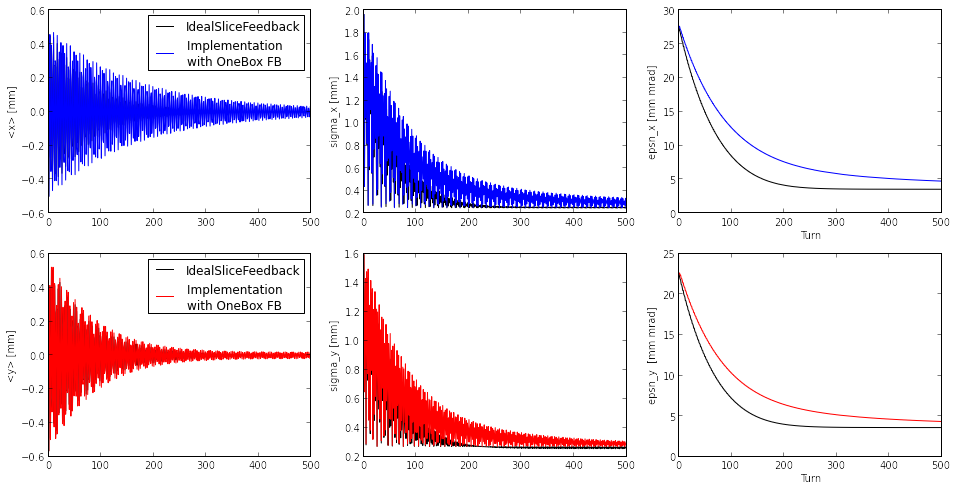

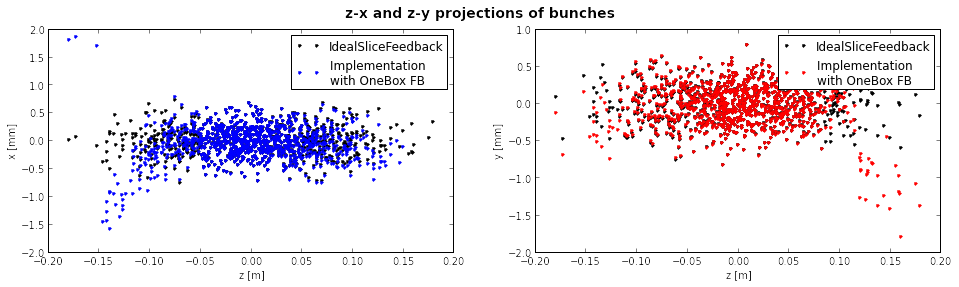

In [37]:
# CASE I:
# Separated pickup and kicker. 
# Note! If you change a position of pickup or kicker, remember to change it to both pickup_position variables
#       and the element order of the total_map


bunch_FB = copy.deepcopy(bunch_ref)
tracker_FB = BunchTracker(bunch_FB)

#Cut off frequencies of the pickup and the kicker
f_c_pickup = 1e12
f_c_kicker = 1e12

# Parameters for the register
# Betatron phase shifts per turn
omega_x = 2.*pi*Q_x
omega_y = 2.*pi*Q_y

pickup_position_x = (0/4.)*2.*pi*Q_x
pickup_position_y = (0/4.)*2.*pi*Q_y
kicker_position_x = (1/4.)*2.*pi*Q_x
kicker_position_y = (1/4.)*2.*pi*Q_y

# register delay [turns]
n_delay = 1
# number of turns averaged
n_avg = 5

# parameters for the inverse weighter
bunch_length = 0.2
bunch_decay_length = 0.1
maximum_weight = 150

# phase conversion coefficients for Averagers (x->xp amplitude conversion)
phase_conv_coeff_x = 0.0148293483363
phase_conv_coeff_y = 0.014820440875

# processor chains (pc) for pickup
pickup_pc_x = [
    ChargeWeighter(),
    LowpassFilter(f_c_pickup),
    CosineSumRegister(n_delay,n_avg,omega_x,pickup_position_x,n_slices, in_processor_chain=False)
    ]
pickup_pc_y = [
    ChargeWeighter(),
    LowpassFilter(f_c_pickup),
    CosineSumRegister(n_delay,n_avg,omega_y,pickup_position_y,n_slices, in_processor_chain=False)
    ]

pickup = PickUp(slicer,pickup_pc_x,pickup_pc_y)


kicker_pc_x = [
    FermiDiracInverseWeighter(bunch_length,bunch_decay_length,maximum_weight),
    PhaseLinearizedLowpass(f_c_kicker)
    ]

kicker_pc_y = [
    FermiDiracInverseWeighter(bunch_length,bunch_decay_length,maximum_weight),
    PhaseLinearizedLowpass(f_c_kicker)
    ]

mixer_x = Averager(phase_conv_coeff_x)
mixer_y = Averager(phase_conv_coeff_y)

register_list_x = [pickup_pc_x[2]]
register_list_y = [pickup_pc_y[2]]

kicker = Kicker(
    kicker_position_x,kicker_position_y,
    feedback_gain,
    slicer,
    register_list_x,register_list_y,
    kicker_pc_x,kicker_pc_y,
    mixer_x,mixer_y)


total_map_FB =  [pickup] + [trans_map[0]] + [kicker] + [trans_map[1]] + [trans_map[2]] + [trans_map[3]] + [long_map] 
    

track(n_turns, bunch_FB,total_map_FB,tracker_FB)

compare_traces(tracker_IdealSliceFB,tracker_FB, 'IdealSliceFeedback', 'Implementation \nwith OneBox FB')
compare_projections( bunch_IdealSliceFB, bunch_FB, 'IdealSliceFeedback', 'Implementation \nwith OneBox FB')

## Two pickups and kicker, comparison of different types of register

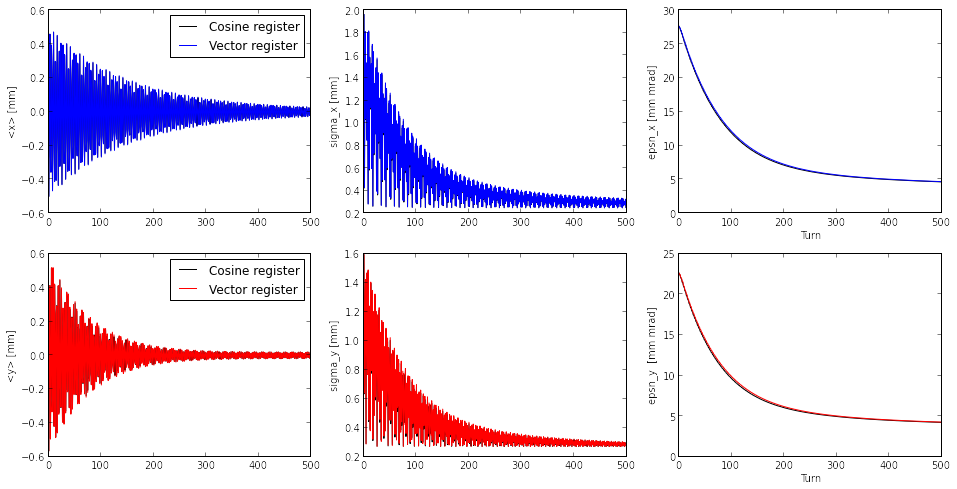

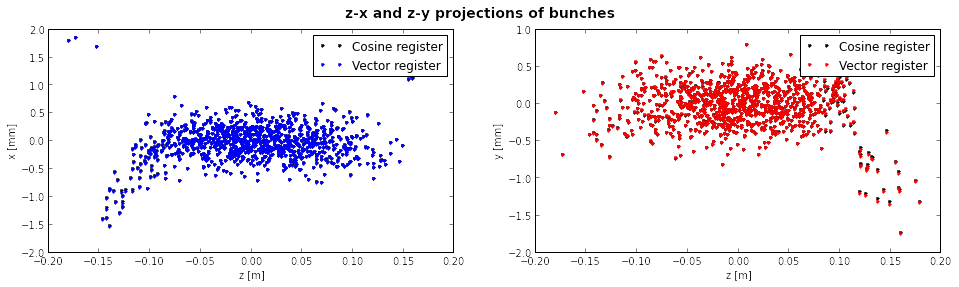

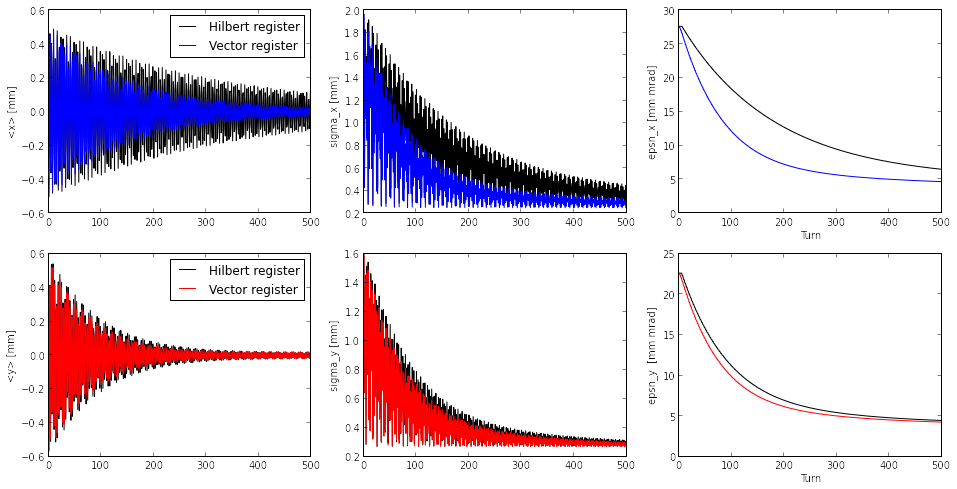

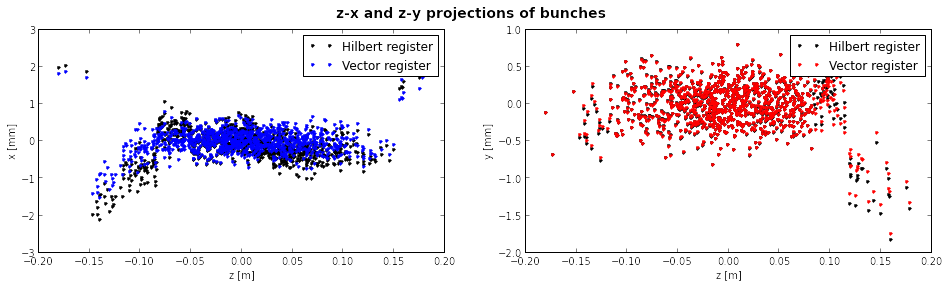

In [38]:
# CASE II
# A feedback system, which consists of four pickups and two kickers.


bunch_cosine = copy.deepcopy(bunch_ref)
tracker_cosine = BunchTracker(bunch_cosine)
slicer_cosine = copy.deepcopy(slicer)

bunch_vector = copy.deepcopy(bunch_ref)
tracker_vector = BunchTracker(bunch_vector)
slicer_vector = copy.deepcopy(slicer)

bunch_hilbert = copy.deepcopy(bunch_ref)
tracker_hilbert = BunchTracker(bunch_hilbert)
slicer_hilbert = copy.deepcopy(slicer)

#Cut off frequencies of the pickup and kicker
f_c_pickup = 1e12
f_c_kicker = 1e12

# parameters for the register
# betatron phase shifts per turn
omega_x = 2.*pi*Q_x
omega_y = 2.*pi*Q_y

# pickup and kicker positions 
p1_x = (0./4.)*2.*pi*Q_x
p1_y = (0./4.)*2.*pi*Q_y

p2_x = (1./4.)*2.*pi*Q_x
p2_y = (1./4.)*2.*pi*Q_y

k_x = (2./4.)*2.*pi*Q_x
k_y = (2./4.)*2.*pi*Q_y

# register delay [turns]
n_delay = 0
# number of turns averaged
n_avg = 7

# parameters for the inverse weighter
bunch_length = 0.2
bunch_decay_length = 0.1
maximum_weight = 150

# Phase conversion coefficients for Averagers (x->xp amplitude conversion)
phase_conv_coeff_x = 0.0148293483363
phase_conv_coeff_y = 0.014820440875

# reference processor chain (pc) for pickups
ppc_ref = [
    ChargeWeighter(),
    LowpassFilter(f_c_pickup)
]

ppc1_cosine_x = copy.deepcopy(ppc_ref)
ppc1_cosine_x += [CosineSumRegister(n_delay,n_avg,omega_x,p1_x,n_slices, in_processor_chain=False)]

ppc1_cosine_y = copy.deepcopy(ppc_ref)
ppc1_cosine_y += [CosineSumRegister(n_delay,n_avg,omega_y,p1_y,n_slices, in_processor_chain=False)]

ppc2_cosine_x = copy.deepcopy(ppc_ref)
ppc2_cosine_x += [CosineSumRegister(n_delay,n_avg,omega_x,p2_x,n_slices, in_processor_chain=False)]

ppc2_cosine_y = copy.deepcopy(ppc_ref)
ppc2_cosine_y += [CosineSumRegister(n_delay,n_avg,omega_y,p2_y,n_slices, in_processor_chain=False)]

ppc1_vector_x = copy.deepcopy(ppc_ref)
ppc1_vector_x += [VectorSumRegister(n_delay,n_avg,omega_x,p1_x,n_slices, in_processor_chain=False)]

ppc1_vector_y = copy.deepcopy(ppc_ref)
ppc1_vector_y += [VectorSumRegister(n_delay,n_avg,omega_y,p1_y,n_slices, in_processor_chain=False)]

ppc2_vector_x = copy.deepcopy(ppc_ref)
ppc2_vector_x += [VectorSumRegister(n_delay,n_avg,omega_x,p2_x,n_slices, in_processor_chain=False)]

ppc2_vector_y = copy.deepcopy(ppc_ref)
ppc2_vector_y += [VectorSumRegister(n_delay,n_avg,omega_y,p2_y,n_slices, in_processor_chain=False)]

ppc1_hilbert_x = copy.deepcopy(ppc_ref)
ppc1_hilbert_x += [HilbertRegister(n_delay,n_avg,omega_x,p1_x,n_slices, in_processor_chain=False)]

ppc1_hilbert_y = copy.deepcopy(ppc_ref)
ppc1_hilbert_y += [HilbertRegister(n_delay,n_avg,omega_y,p1_y,n_slices, in_processor_chain=False)]

ppc2_hilbert_x = copy.deepcopy(ppc_ref)
ppc2_hilbert_x += [HilbertRegister(n_delay,n_avg,omega_x,p2_x,n_slices, in_processor_chain=False)]

ppc2_hilbert_y = copy.deepcopy(ppc_ref)
ppc2_hilbert_y += [HilbertRegister(n_delay,n_avg,omega_y,p2_y,n_slices, in_processor_chain=False)]

registers_cosine_x = [ppc1_cosine_x[2],ppc2_cosine_x[2]]
registers_cosine_y = [ppc1_cosine_y[2],ppc2_cosine_y[2]]

registers_vector_x = [ppc1_vector_x[2],ppc2_vector_x[2]]
registers_vector_y = [ppc1_vector_y[2],ppc2_vector_y[2]]

registers_hilbert_x = [ppc1_hilbert_x[2],ppc2_hilbert_x[2]]
registers_hilbert_y = [ppc1_hilbert_y[2],ppc2_hilbert_y[2]]

pickup_1_cosine = PickUp(slicer_cosine,ppc1_cosine_x,ppc1_cosine_y)
pickup_2_cosine = PickUp(slicer_cosine,ppc2_cosine_x,ppc2_cosine_y)

pickup_1_vector = PickUp(slicer_vector,ppc1_vector_x,ppc1_vector_y)
pickup_2_vector = PickUp(slicer_vector,ppc2_vector_x,ppc2_vector_y)

pickup_1_hilbert = PickUp(slicer_hilbert,ppc1_hilbert_x,ppc1_hilbert_y)
pickup_2_hilbert = PickUp(slicer_hilbert,ppc2_hilbert_x,ppc2_hilbert_y)

kpc_x = [
    FermiDiracInverseWeighter(bunch_length,bunch_decay_length,maximum_weight),
    PhaseLinearizedLowpass(f_c_kicker)
    ]
kpc_y = [
    FermiDiracInverseWeighter(bunch_length,bunch_decay_length,maximum_weight),
    PhaseLinearizedLowpass(f_c_kicker)
    ]

mixer_x = Averager(phase_conv_coeff_x)
mixer_y = Averager(phase_conv_coeff_y)



kicker_cosine = Kicker(
    k_x,k_y,
    feedback_gain,
    slicer_cosine,
    registers_cosine_x,registers_cosine_y,
    kpc_x,kpc_y,
    mixer_x,mixer_y)

kicker_vector = Kicker(
    k_x,k_y,
    feedback_gain,
    slicer_vector,
    registers_vector_x,registers_vector_y,
    kpc_x,kpc_y,
    mixer_x,mixer_y)

kicker_hilbert = Kicker(
    k_x,k_y,
    feedback_gain,
    slicer_vector,
    registers_hilbert_x,registers_hilbert_y,
    kpc_x,kpc_y,
    mixer_x,mixer_y)

total_map_cosine = [pickup_1_cosine] + [trans_map[0]] + [pickup_2_cosine] + [trans_map[1]] + \
                   [kicker_cosine] + [trans_map[2]] + [trans_map[3]] + [long_map] 

total_map_vector = [pickup_1_vector] + [trans_map[0]] + [pickup_2_vector] + [trans_map[1]] + \
                   [kicker_vector] + [trans_map[2]] + [trans_map[3]] + [long_map] 
    
total_map_hilbert = [pickup_1_hilbert] + [trans_map[0]] + [pickup_2_hilbert] + [trans_map[1]] + \
                   [kicker_hilbert] + [trans_map[2]] + [trans_map[3]] + [long_map] 
    
track(n_turns, bunch_cosine,total_map_cosine,tracker_cosine)
track(n_turns, bunch_vector,total_map_vector,tracker_vector)
track(n_turns, bunch_hilbert,total_map_hilbert,tracker_hilbert)

compare_traces(tracker_cosine,tracker_vector, 'Cosine register', 'Vector register')
compare_projections(bunch_cosine, bunch_vector, 'Cosine register', 'Vector register')
compare_traces(tracker_hilbert,tracker_vector, 'Hilbert register', 'Vector register')
compare_projections(bunch_hilbert, bunch_vector, 'Hilbert register', 'Vector register')

## Multi pickups and kickers

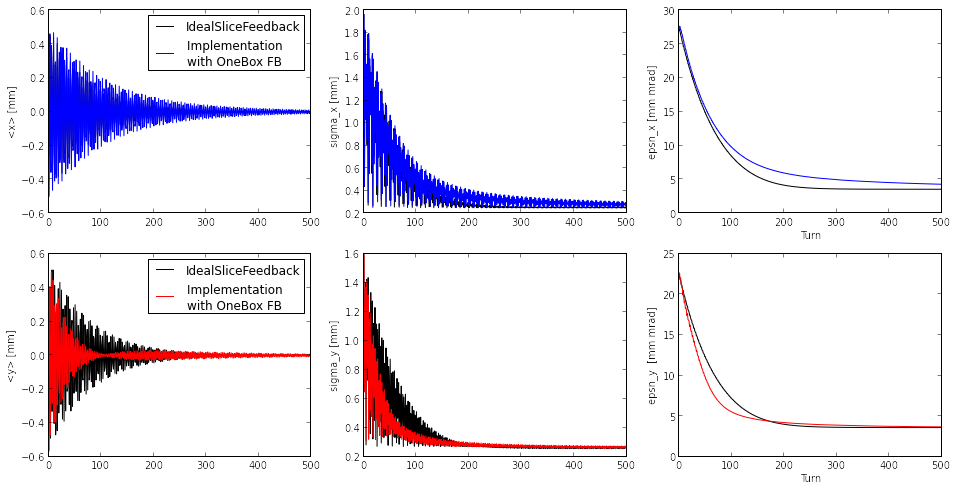

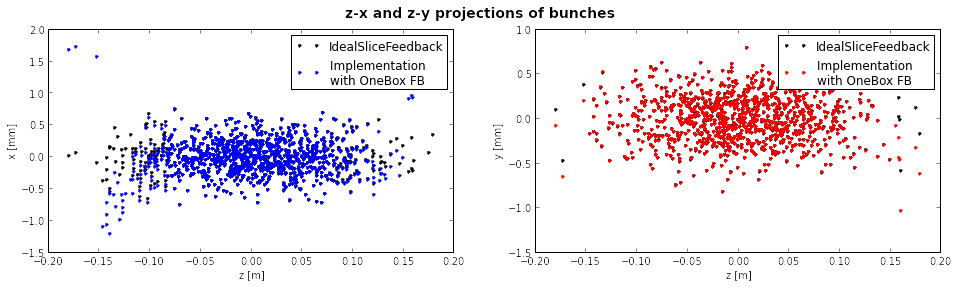

In [39]:
# CASE II
# A feedback system, which consists of four pickups and two kickers.


bunch_FB = copy.deepcopy(bunch_ref)
tracker_FB = BunchTracker(bunch_FB)

#Cut off frequency of the pickup and the kicker
f_c_pickup = 1e12
f_c_kicker = 1e12

# parameters of the register
# betatron phase shifts per turn
omega_x = 2.*pi*Q_x
omega_y = 2.*pi*Q_y
# register delay [turns]
n_delay = 1
# number of turns averaged
n_avg = 7

# Parameters for the inverse weighter
bunch_length = 0.2
bunch_decay_length = 0.1
maximum_weight = 150

# Phase conversion coefficients for Averagers (x->xp amplitude conversion)
phase_conv_coeff_x = 0.0148293483363
phase_conv_coeff_y = 0.014820440875

# reference processor chain (pc) for pickups
pickup_pc_ref_x = [
    ChargeWeighter(),
    LowpassFilter(f_c_pickup),
    VectorSumRegister(n_delay,n_avg,omega_x,0,n_slices, in_processor_chain=False)
    # CosineSumRegister(n_delay,n_avg,omega_x,0,n_slices, in_processor_chain=False)
    # HilbertRegister(n_delay,n_avg,omega_x,0,n_slices, in_processor_chain=False)
    ]
pickup_pc_ref_y = [
    ChargeWeighter(),
    LowpassFilter(f_c_pickup),
    VectorSumRegister(n_delay,n_avg,omega_y,0,n_slices, in_processor_chain=False)
    # CosineSumRegister(n_delay,n_avg,omega_y,0,n_slices, in_processor_chain=False)
    # HilbertRegister(n_delay,n_avg,omega_y,0,n_slices, in_processor_chain=False)
    ]

pickup_pc_x_1 = copy.deepcopy(pickup_pc_ref_x)
pickup_pc_x_1[2].position = (0./4.)*2.*pi*Q_x
pickup_pc_y_1 = copy.deepcopy(pickup_pc_ref_y)
pickup_pc_y_1[2].position = (0./4.)*2.*pi*Q_y

pickup_pc_x_2 = copy.deepcopy(pickup_pc_ref_x)
pickup_pc_x_2[2].position = (1./4.)*2.*pi*Q_x
pickup_pc_y_2 = copy.deepcopy(pickup_pc_ref_y)
pickup_pc_y_2[2].position = (1./4.)*2.*pi*Q_y

pickup_pc_x_3 = copy.deepcopy(pickup_pc_ref_x)
pickup_pc_x_3[2].position = (2./4.)*2.*pi*Q_x
pickup_pc_y_3 = copy.deepcopy(pickup_pc_ref_y)
pickup_pc_y_3[2].position = (2./4.)*2.*pi*Q_y

pickup_pc_x_4 = copy.deepcopy(pickup_pc_ref_x)
pickup_pc_x_4[2].position = (3./4.)*2.*pi*Q_x
pickup_pc_y_4 = copy.deepcopy(pickup_pc_ref_y)
pickup_pc_y_4[2].position = (3./4.)*2.*pi*Q_y

pickup_1 = PickUp(slicer,pickup_pc_x_1,pickup_pc_y_1)
pickup_2 = PickUp(slicer,pickup_pc_x_2,pickup_pc_y_2)
pickup_3 = PickUp(slicer,pickup_pc_x_3,pickup_pc_y_3)
pickup_4 = PickUp(slicer,pickup_pc_x_4,pickup_pc_y_4)

kicker_pc_ref = [
    FermiDiracInverseWeighter(bunch_length,bunch_decay_length,maximum_weight),
    PhaseLinearizedLowpass(f_c_kicker)
    ]

kicker_pc_x_1 = copy.deepcopy(kicker_pc_ref)
kicker_pc_y_1 = copy.deepcopy(kicker_pc_ref)
kicker_pc_x_2 = copy.deepcopy(kicker_pc_ref)
kicker_pc_y_2 = copy.deepcopy(kicker_pc_ref)


mixer_x = Averager(phase_conv_coeff_x)
mixer_y = Averager(phase_conv_coeff_y)

register_list_x = [pickup_pc_x_1[2],pickup_pc_x_2[2],pickup_pc_x_3[2],pickup_pc_x_4[2]]
register_list_y = [pickup_pc_y_1[2],pickup_pc_y_2[2],pickup_pc_y_3[2],pickup_pc_y_4[2]]

kicker_1 = Kicker(
    (1./4.)*2.*pi*Q_x,(1./4.)*2.*pi*Q_y,
    feedback_gain,
    slicer,
    register_list_x,register_list_y,
    kicker_pc_x_1,kicker_pc_y_1,
    mixer_x,mixer_y)

kicker_2 = Kicker(
    (3./4.)*2.*pi*Q_x,(3./4.)*2.*pi*Q_y,
    feedback_gain,
    slicer,
    register_list_x,register_list_y,
    kicker_pc_x_2,kicker_pc_y_2,
    mixer_x,mixer_y)

total_map_FB = [pickup_1] + [trans_map[0]] + [pickup_2] + [kicker_1] + [trans_map[1]] + \
               [pickup_3] + [trans_map[2]] + [pickup_4] + [kicker_2] + [trans_map[3]] + [long_map] 

track(n_turns, bunch_FB,total_map_FB,tracker_FB)

compare_traces(tracker_IdealSliceFB,tracker_FB, 'IdealSliceFeedback', 'Implementation \nwith OneBox FB')
compare_projections( bunch_IdealSliceFB, bunch_FB, 'IdealSliceFeedback', 'Implementation \nwith OneBox FB')